# Custom Training: Walkthrough

The goal of this notebook will be to make a model that classifies 3 different kinds of Iris flowers based on "petal" and "sepal" length and width measurements.

In [1]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 1.13.1
Eager execution: True


## Data

In [2]:
# Download the dataset
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url), origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

Local copy of the dataset file: /home/waydegg/.keras/datasets/iris_training.csv


Inspect Data

In [3]:
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


In [4]:
# column order in CSV file
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


Use tensorflow's dataset api to load data into a model

In [5]:
batch_size = 32

train_dataset = tf.contrib.data.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1
)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.data.experimental.make_csv_dataset(...)`.


In [6]:
# Look at a batch of features from the previously created dataset
features, labels = next(iter(train_dataset))

features

Instructions for updating:
Colocations handled automatically by placer.


OrderedDict([('sepal_length',
              <tf.Tensor: id=58, shape=(32,), dtype=float32, numpy=
              array([5. , 5.7, 6.1, 6.6, 5.4, 5. , 5.7, 6.7, 7.2, 5.8, 5.8, 6.4, 6.2,
                     6.6, 7.3, 4.6, 7.7, 5.1, 6.4, 7.4, 5. , 4.5, 6.8, 5. , 5.9, 6.7,
                     5.8, 6.1, 5.9, 4.6, 4.4, 6.4], dtype=float32)>),
             ('sepal_width',
              <tf.Tensor: id=59, shape=(32,), dtype=float32, numpy=
              array([3.6, 2.8, 2.8, 2.9, 3.4, 3.2, 2.8, 3. , 3.6, 2.6, 2.7, 2.7, 3.4,
                     3. , 2.9, 3.1, 2.8, 2.5, 3.2, 2.8, 3.4, 2.3, 2.8, 2. , 3.2, 3. ,
                     2.7, 3. , 3. , 3.4, 2.9, 2.8], dtype=float32)>),
             ('petal_length',
              <tf.Tensor: id=56, shape=(32,), dtype=float32, numpy=
              array([1.4, 4.1, 4.7, 4.6, 1.5, 1.2, 4.5, 5.2, 6.1, 4. , 5.1, 5.3, 5.4,
                     4.4, 6.3, 1.5, 6.7, 3. , 4.5, 6.1, 1.6, 1.3, 4.8, 3.5, 4.8, 5. ,
                     5.1, 4.9, 5.1, 1.4, 1.4, 5.6],

Text(0, 0.5, 'Sepal length')

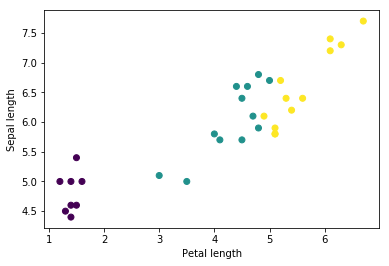

In [7]:
plt.scatter(features['petal_length'].numpy(),
            features['sepal_length'].numpy(),
            c=labels.numpy(),
            cmap='viridis')
           
plt.xlabel("Petal length")
plt.ylabel("Sepal length")
           

Simplify the model building step by "repacking" the features dictionary into a single array with shape (batch_size, num_features)

In [8]:
def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

In [9]:
# 'tf.data.Dataset.map' packs the features of each (features,label) pair into the training dataset
train_dataset = train_dataset.map(pack_features_vector)

In [10]:
features, labels = next(iter(train_dataset))

print(features[:5])

tf.Tensor(
[[6.  2.2 5.  1.5]
 [4.4 3.  1.3 0.2]
 [5.  3.  1.6 0.2]
 [6.5 3.  5.2 2. ]
 [6.7 3.1 5.6 2.4]], shape=(5, 4), dtype=float32)


## Modeling

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)), # input shape required
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(3)
])

In [12]:
predictions = model(features)
predictions[:5]

<tf.Tensor: id=200, shape=(5, 3), dtype=float32, numpy=
array([[-0.32353777, -0.35815305,  0.01139457],
       [-0.7282854 , -0.66233414, -0.24644996],
       [-0.7291588 , -0.66576904, -0.26346177],
       [-0.4110444 , -0.43567547, -0.02508365],
       [-0.41668847, -0.45152175, -0.00525801]], dtype=float32)>

Since the raw output is ```logits```, we need to convert them to probabilities with a ```softmax``` function:

In [13]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: id=206, shape=(5, 3), dtype=float32, numpy=
array([[0.29728082, 0.28716645, 0.41555277],
       [0.27120718, 0.28969663, 0.4390962 ],
       [0.2733311 , 0.29121846, 0.43545043],
       [0.29013285, 0.28307387, 0.42679328],
       [0.2877912 , 0.2779391 , 0.4342697 ]], dtype=float32)>

```tf.argmax``` gives us the predicted class index (though poor accuracy as the model hasn't been trained)

In [14]:
print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))

Prediction: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
    Labels: [2 0 0 2 2 2 0 0 0 0 2 2 0 0 0 2 0 2 2 1 1 2 2 1 0 0 2 0 0 0 1 1]


Define loss function

In [15]:
def loss(model, x, y):
    y_ = model(x)
    return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

l = loss(model, features, labels)
print("Loss test: {}".format(l))

Instructions for updating:
Use tf.cast instead.
Loss test: 1.1373370885849


Use ```tf.GradientTape``` to calculate the gradients used to optimize our model

In [16]:
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
        
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

Define optimizer

In [17]:
# The below optimizer implements the Stochastic Gradient Descent (SGD) algorithim
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

global_step = tf.Variable(0)

In [18]:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(global_step.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables), global_step)

print("Step: {},         Loss: {}".format(global_step.numpy(),
                                           loss(model, features, labels).numpy()))

Step: 0, Initial Loss: 1.1373370885849
Step: 1,         Loss: 1.1184331178665161


Creating the Training Loop

In [19]:
# Re-running this cell uses the same model variables

from tensorflow import contrib
tfe = contrib.eager

# keep results for plotting
train_loss_results = []
train_accuracy_results = []
num_epochs = 201

for epoch in range(num_epochs):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()
    
    # Training loop - using batches of 32
    for x, y in train_dataset:
        # Optimize the model
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables),
                                 global_step)
        
        # Track progress
        epoch_loss_avg(loss_value) # add current batch loss
        # compare predicted label to actual label
        epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)
        
    # end epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    if epoch % 50 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                    epoch_loss_avg.result(),
                                                                    epoch_accuracy.result()))

Epoch 000: Loss: 1.117, Accuracy: 35.000%
Epoch 050: Loss: 0.515, Accuracy: 76.667%
Epoch 100: Loss: 0.290, Accuracy: 95.833%
Epoch 150: Loss: 0.185, Accuracy: 97.500%
Epoch 200: Loss: 0.138, Accuracy: 98.333%


## Eval

Visualize the loss funtion over time

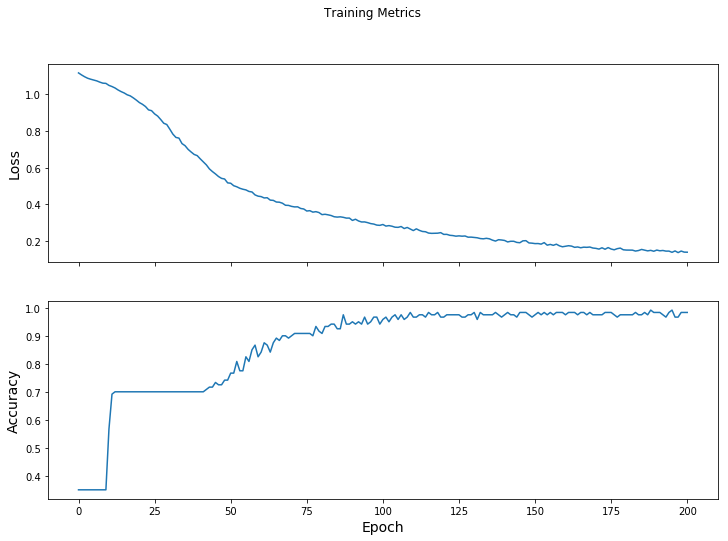

In [20]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12,8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results);

Evaluate the model against a test set

In [21]:
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

In [22]:
test_dataset = tf.contrib.data.make_csv_dataset(
    test_fp,
    batch_size,
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False
)

test_dataset = test_dataset.map(pack_features_vector)

In [23]:
test_accuracy = tfe.metrics.Accuracy()

for (x,y) in test_dataset:
    logits = model(x)
    prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
    test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 96.667%


See results on last batch

In [24]:
tf.stack([y,prediction], axis=1)

<tf.Tensor: id=107884, shape=(30, 2), dtype=int32, numpy=
array([[1, 1],
       [2, 2],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [2, 2],
       [1, 1],
       [2, 2],
       [2, 2],
       [0, 0],
       [2, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1]], dtype=int32)>

Make predictions on some unlabeled examples

In [25]:
class_names = ["Iris setosa", "Iris versicolor", "Iris virginica"]

In [26]:
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predict_dataset):
    class_idx = tf.argmax(logits).numpy()
    p = tf.nn.softmax(logits)[class_idx]
    name = class_names[class_idx]
    print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 prediction: Iris setosa (82.7%)
Example 1 prediction: Iris setosa (80.0%)
Example 2 prediction: Iris setosa (79.8%)
